# simplier version of Pytorch Dataloader Inference (Swin transformer)

In [1]:
#  not used !pip install git+file:///kaggle/input/effnetpytorch/EfficientUnet-PyTorch

In [10]:
import tifffile
from glob import glob
import cv2 as cv
import os
import sys

In [11]:
sys.path.append('../swin-transformer-rebuild/')

In [12]:
from pathlib import Path
from typing import Any
from typing import Callable
from typing import Dict
from typing import Optional
from typing import Tuple

import numpy as np
import pandas as pd


import seaborn as sns
import tifffile
import random

In [100]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import albumentations as A
import albumentations.pytorch

In [14]:
TEST_CSV = './../data/train.csv'
TEST_IMAGES_DIR = './../data/train_images/'

N_CROSS_VALID_SPLITS = 5
RANDOM_SEED = 2022
CURRENT_FOLD = 0

SPATIAL_SIZE = 768 # размер патча
BATCH_SIZE = 2
# TEST_IMAGES_DIR = './../data/test_images/' # one image - not in use

In [15]:
def make_train_image_path(row):
    return os.path.join(TEST_IMAGES_DIR, str(row['id']) + '.tiff')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [16]:
test_df = pd.read_csv(TEST_CSV)
test_df['image'] = test_df.apply(make_train_image_path, axis=1)

In [17]:
device = 'cuda:3'

In [18]:
cfg = dict(
        output_type=['inference'],
        #configs/_base_/models/upernet_swin.py
        basic = dict(
            swin=dict(
                embed_dim=96,
                depths=[2, 2, 6, 2],
                num_heads=[3, 6, 12, 24],
                window_size=7,
                mlp_ratio=4.,
                qkv_bias=True,
                qk_scale=None,
                drop_rate=0.,
                attn_drop_rate=0.,
                drop_path_rate=0.3,
                ape=False,
                patch_norm=True,
                out_indices=(0, 1, 2, 3),
                use_checkpoint=False
            ),

        ),

        #configs/swin/upernet_swin_tiny_patch4_window7_512x512_160k_ade20k.py
        swin_tiny_patch4_window7_224=dict(
            checkpoint = None, #pretrain_dir+'/swin_tiny_patch4_window7_224_22k.pth',

            swin = dict(
                embed_dim=96,
                depths=[2, 2, 6, 2],
                num_heads=[3, 6, 12, 24],
                window_size=7,
                ape=False,
                drop_path_rate=0.3,
                patch_norm=True,
                use_checkpoint=False,
            ),
            upernet=dict(
                in_channels=[96, 192, 384, 768],
            ),
        ),

        #/configs/swin/upernet_swin_small_patch4_window7_512x512_160k_ade20k.py
        swin_small_patch4_window7_224_22k=dict(
            checkpoint = None, #pretrain_dir+'/swin_small_patch4_window7_224_22k.pth',

            swin = dict(
                embed_dim=96,
                depths=[2, 2, 18, 2],
                num_heads=[3, 6, 12, 24],
                window_size=7,
                ape=False,
                drop_path_rate=0.3,
                patch_norm=True,
                use_checkpoint=False
            ),
            upernet=dict(
                in_channels=[96, 192, 384, 768],
            ),
        ),
    )

In [19]:
from swintransformer import Net

models = [Net(cfg).to(device) for _ in range(1)]
for i, bname in enumerate(['./../swin-transformer-rebuild/fold-0/checkpoint/00013020.model.pth']):
#                            './../swin-transformer-rebuild/fold-1/checkpoint/00013020.model.pth', 
#                            './../swin-transformer-rebuild/fold-2/checkpoint/00013020.model.pth', 
#                            './../swin-transformer-rebuild/fold-3/checkpoint/00013020.model.pth']):
    f = torch.load(bname, map_location=torch.device(device))
    models[i].load_state_dict(f['state_dict'])
    

for i in range(len(models)):
    models[i].eval()

/opt/conda/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [164]:
class HubmapTestDataset(Dataset):   
    def __init__(self, df, transform):
    
        print('-' * 40)
        print('hubmap simple dataset (Total {} samples)'.format(len(df)))
        print('-' * 40)
        
        self.df = df
        self.transform = transform
        

    def __len__(self):
        return len(self.df) # * self.runtime_frame_repeats

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = tifffile.imread(row['image'])
        
        orig_shape = img.shape[:2]
        
#         img = cv.cvtColor(img, cv.COLOR_BGR2RGB) 

        mask = np.load('./../data/train_masks/{}.npy'.format(row['id']))
        
        data = self.transform(image=img, mask=mask)
        

        
        data.update({
            'original_shape_0': orig_shape[0],
            'original_shape_1': orig_shape[1],
            'id': row['id']
        })
        
        return data

In [165]:
def mask2rle(img):
    '''
    Efficient implementation of mask2rle, from @paulorzp
    --
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    Source: https://www.kaggle.com/xhlulu/efficient-mask2rle
    '''
    pixels = img.T.flatten()
    pixels = np.pad(pixels, ((1, 1), ))
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# changing spatial size

In [153]:
test_transform = A.Compose([
    A.Resize(768, 768, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), 
                 max_pixel_value=255.0, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [154]:
test_transform_767 = A.Compose([
    A.Resize(767, 767, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), 
                 max_pixel_value=255.0, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [155]:
test_transform_512 = A.Compose([
    A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), 
                 max_pixel_value=255.0, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [156]:
test_transform_256 = A.Compose([
    A.Resize(256, 256, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), 
                 max_pixel_value=255.0, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [157]:
test_transform_224 = A.Compose([
    A.Resize(224, 224, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), 
                 max_pixel_value=255.0, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [158]:
test_transform_200 = A.Compose([
    A.Resize(200, 200, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), 
                 max_pixel_value=255.0, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [159]:
test_transform_1400 = A.Compose([
    A.Resize(1400, 1400, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), 
                 max_pixel_value=255.0, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [160]:
test_dataset     = HubmapTestDataset(test_df, test_transform)
test_dataset_767 = HubmapTestDataset(test_df, test_transform_767)
test_dataset_512 = HubmapTestDataset(test_df, test_transform_512)
test_dataset_256 = HubmapTestDataset(test_df, test_transform_256)
test_dataset_224 = HubmapTestDataset(test_df, test_transform_224)
test_dataset_200 = HubmapTestDataset(test_df, test_transform_200)
test_dataset_1400 = HubmapTestDataset(test_df, test_transform_1400)

----------------------------------------
hubmap simple dataset (Total 351 samples)
----------------------------------------
----------------------------------------
hubmap simple dataset (Total 351 samples)
----------------------------------------
----------------------------------------
hubmap simple dataset (Total 351 samples)
----------------------------------------
----------------------------------------
hubmap simple dataset (Total 351 samples)
----------------------------------------
----------------------------------------
hubmap simple dataset (Total 351 samples)
----------------------------------------
----------------------------------------
hubmap simple dataset (Total 351 samples)
----------------------------------------
----------------------------------------
hubmap simple dataset (Total 351 samples)
----------------------------------------


In [161]:
@torch.no_grad()
def predict(models, dataset, index):
    THRESHOLD = 0.5
    batch = dataset[index]
    
    outputs_folded = []            
    id_ = batch["id"]
    height = batch["original_shape_0"]
    width  = batch["original_shape_1"] 
        
    with torch.no_grad():
        for i in range(len(models)):
            batch["image"] = batch["image"].unsqueeze(0).to(device)
            outputs = models[i](batch)

            outputs = outputs['probability'][0].detach().cpu().numpy()[0]
            outputs_folded.append(outputs)
        conct = np.array(outputs_folded)
        outputs_folded = (conct.mean(axis=0) > THRESHOLD).astype(np.uint8)

    mask = cv.resize(outputs_folded, (width, height), interpolation=cv.INTER_NEAREST)

    orig_image = cv.imread('./../data/train_images/{}.tiff'.format(id_))
    orig_image = orig_image[:, :, ::-1]
    
    fig, ax = plt.subplots(1, 4, figsize=(21, 8))
    fig.suptitle('Horizontally stacked subplots')
    ax[0].imshow(orig_image)
    ax[1].imshow(batch['mask'])
    ax[2].imshow(mask)
    
#     print(batch['mask'])
    
    delta = np.abs(cv.resize(batch['mask'].cpu().numpy(), mask.shape[:2]).astype(np.float32) - 
                   mask)
    
    ax[3].imshow(delta, cmap='Reds', vmin=0.0, vmax=1.0)



In [163]:
test_dataset[0]['id']

10044

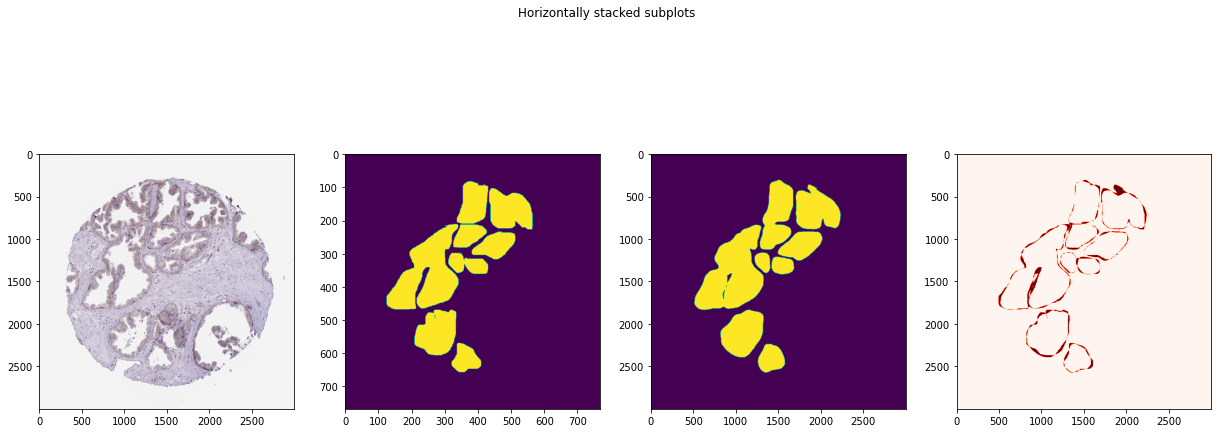

In [85]:
predict(models, test_dataset, 0)

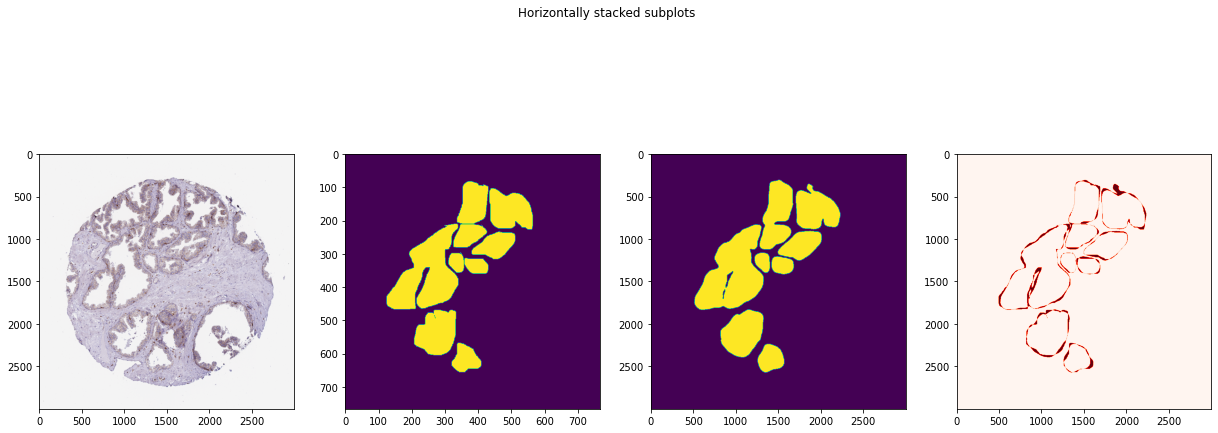

In [86]:
predict(models, test_dataset_767, 0)

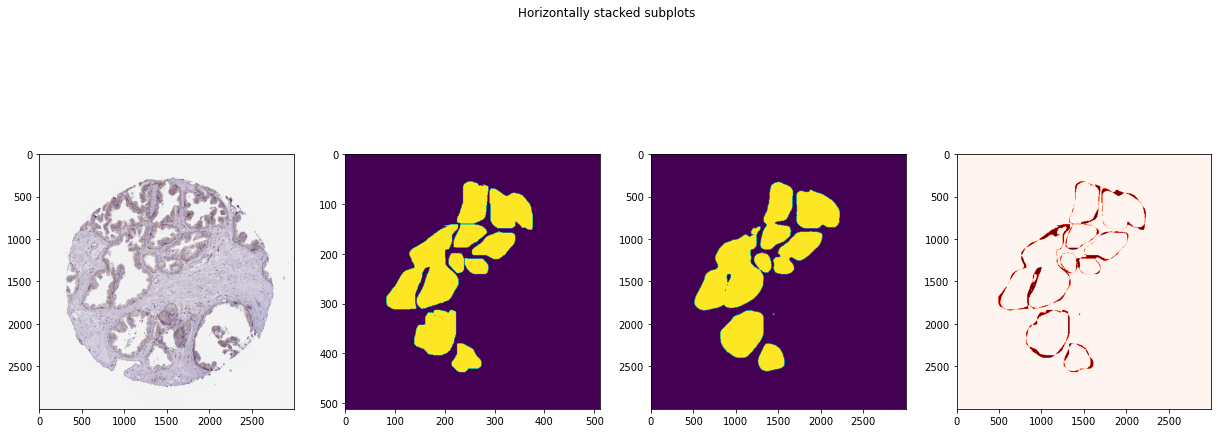

In [87]:
predict(models, test_dataset_512, 0)

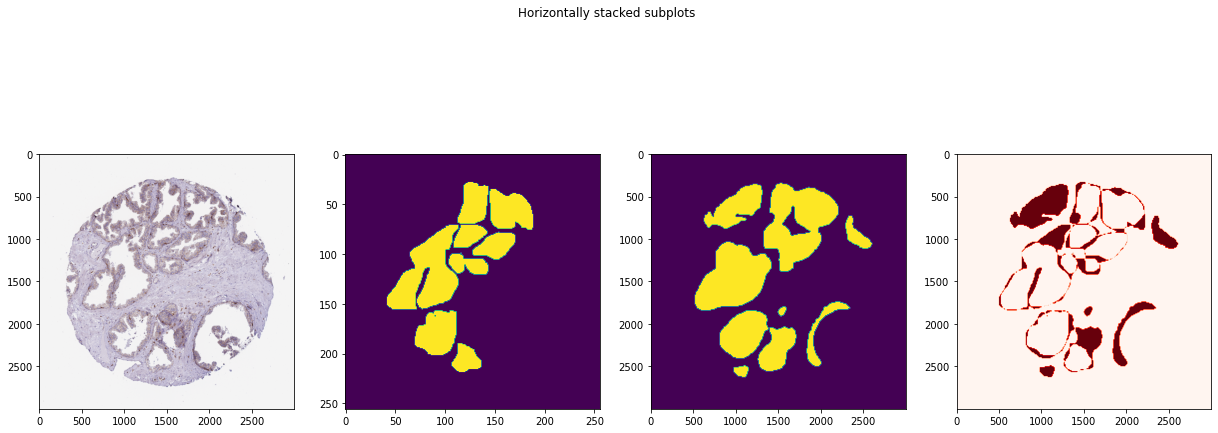

In [88]:
predict(models, test_dataset_256, 0)

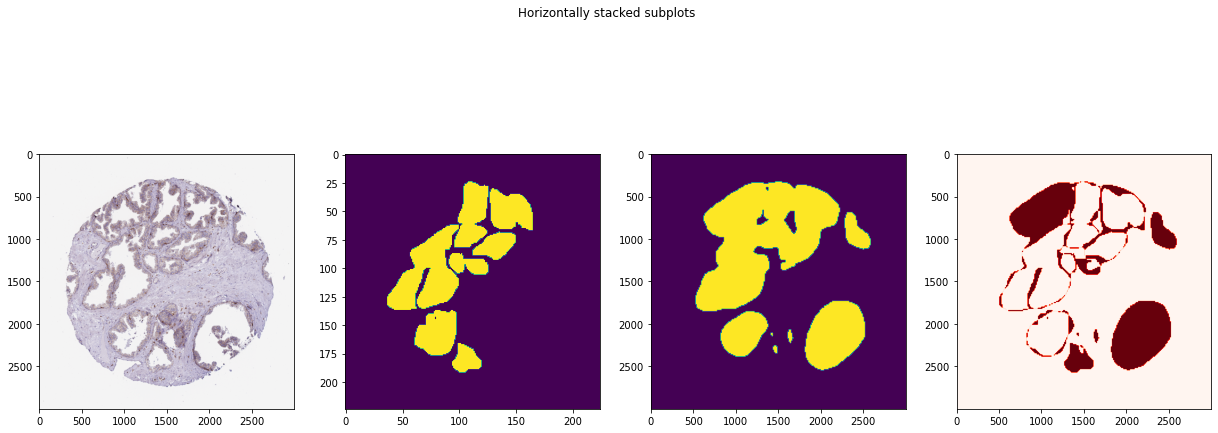

In [89]:
predict(models, test_dataset_224, 0)

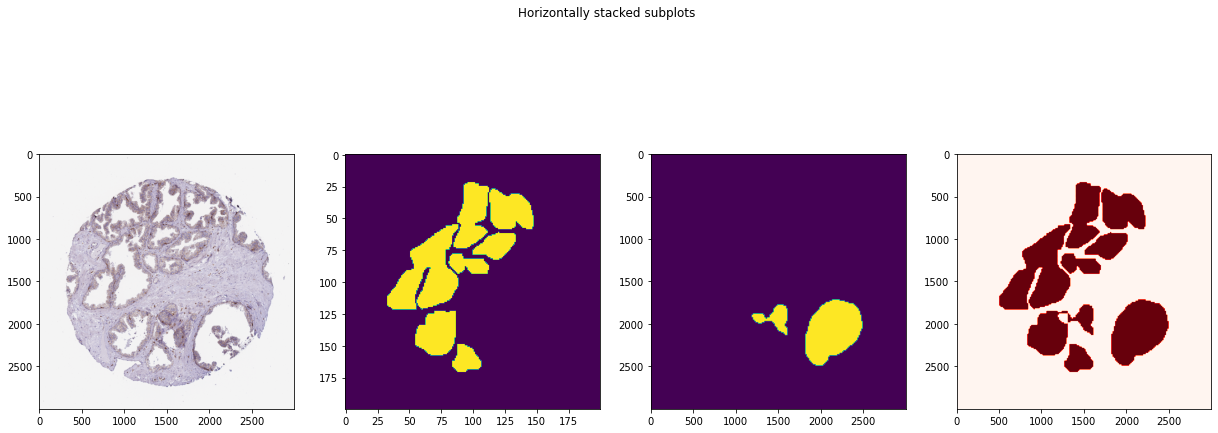

In [92]:
predict(models, test_dataset_200, 0)

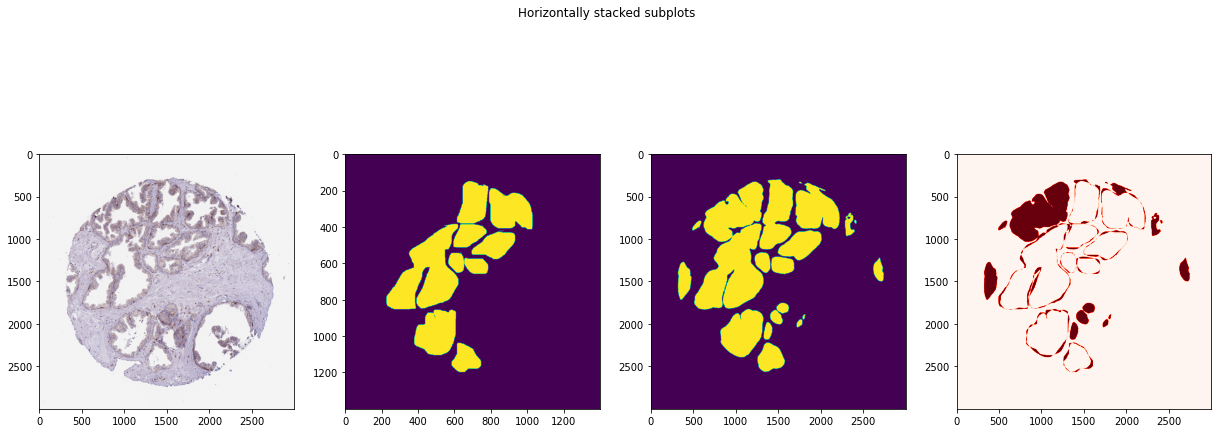

In [162]:
predict(models, test_dataset_1400, 0)

# extra than 768 x 768

In [98]:
ARR = np.array([[1, 2, 3]])

In [99]:
np.stack([ARR, ARR], axis=1)

array([[[1, 2, 3],
        [1, 2, 3]]])

In [143]:
class HubmapTestDataset(Dataset):   
    def __init__(self, df, transform):
    
        print('-' * 40)
        print('hubmap simple dataset (Total {} samples)'.format(len(df)))
        print('-' * 40)
        
        self.df = df
        self.transform = transform
        

    def __len__(self):
        return len(self.df) # * self.runtime_frame_repeats

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = tifffile.imread(row['image'])
        
        orig_shape = img.shape[:2]
        
#         img = cv.cvtColor(img, cv.COLOR_BGR2RGB) 

        mask = np.load('./../data/train_masks/{}.npy'.format(row['id']))
        
        # ---------------
        # break in
        

        
        
        # ---------------
        
        data = self.transform(image=img, mask=mask)
        
        
        
        data.update({
            'original_shape_0': orig_shape[0],
            'original_shape_1': orig_shape[1],
            'id': row['id']
        }) 
        
        mask = data['mask']
        img = data['image']
        
        mask = torch.cat([mask, mask], dim=0)
        print(mask.shape)
        mask = torch.cat([mask, mask], dim=1)
        print(mask.shape)
        
        
        img = torch.cat([img, img], dim=1)
        img = torch.cat([img, img], dim=2)
        
        data['mask'] =  mask
        data['image'] = img
        
        return data

In [144]:
test_transform_x2 = A.Compose([
    A.Resize(768, 768, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), 
                 max_pixel_value=255.0, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [145]:
test_dataset_x2     = HubmapTestDataset(test_df, test_transform_x2)

----------------------------------------
hubmap simple dataset (Total 351 samples)
----------------------------------------


In [146]:
@torch.no_grad()
def predict(models, dataset, index):
    THRESHOLD = 0.5
    batch = dataset[index]
    
    outputs_folded = []            
    id_ = batch["id"]
    height = batch["original_shape_0"]
    width  = batch["original_shape_1"] 
        
    with torch.no_grad():
        for i in range(len(models)):
            batch["image"] = batch["image"].unsqueeze(0).to(device)
            outputs = models[i](batch)

            outputs = outputs['probability'][0].detach().cpu().numpy()[0]
            outputs_folded.append(outputs)
        conct = np.array(outputs_folded)
        outputs_folded = (conct.mean(axis=0) > THRESHOLD).astype(np.uint8)

    mask = cv.resize(outputs_folded, (width, height), interpolation=cv.INTER_NEAREST)

    orig_image = batch['image'][0].permute((1, 2, 0)).detach().cpu().numpy()
    
    fig, ax = plt.subplots(1, 4, figsize=(21, 8))
    fig.suptitle('Horizontally stacked subplots')
    ax[0].imshow(orig_image)
    ax[1].imshow(batch['mask'])
    ax[2].imshow(mask)
    
#     print(batch['mask'])
    
    delta = np.abs(cv.resize(batch['mask'].cpu().numpy(), mask.shape[:2]).astype(np.float32) - 
                   mask)
    
    ax[3].imshow(delta, cmap='Reds', vmin=0.0, vmax=1.0)



torch.Size([1536, 768])
torch.Size([1536, 1536])


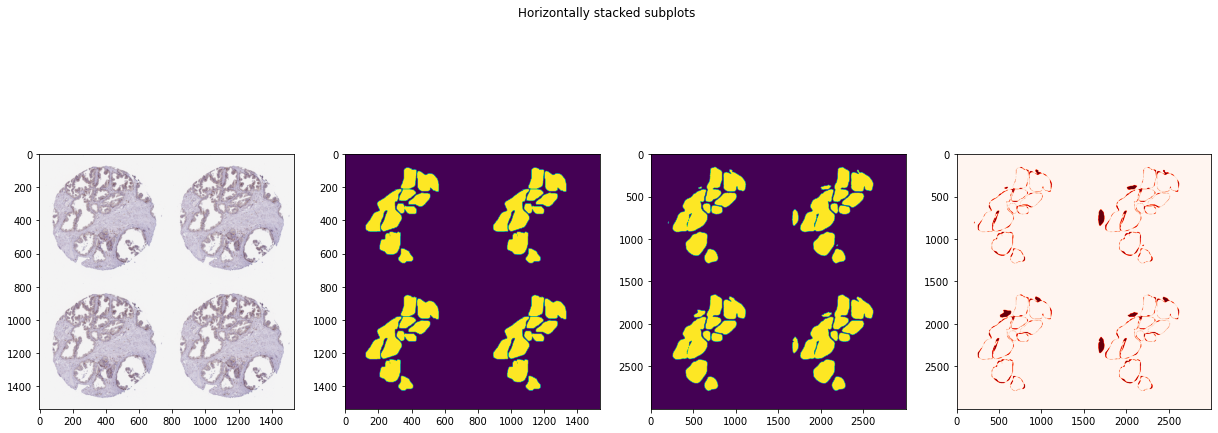

In [147]:
predict(models, test_dataset_x2, 0)

# white padding is bad?

In [168]:
def pad_to_SIZE(x):
    SIZE = 512
    padv = 0
    padh = 0
    if x.shape[0] < SIZE:
        padv = SIZE - x.shape[0]
    
    if x.shape[1] < SIZE:
        padh = SIZE - x.shape[1]
     
    padv1 = padv // 2
    padv2 = padv - padv1
    
    padh1 = padh // 2
    padh2 = padh - padh1
    
    canvas = np.ones((max(SIZE, x.shape[0]), max(SIZE, x.shape[1]), 3), dtype=np.uint8) * 255
    
    canvas[padv1:padv1 + x.shape[0], padh1:padh1 + x.shape[1]] = x
    
    roi = np.array([padv1, padv1 + x.shape[0], padh1, padh1 + x.shape[1]])
    
    return canvas, roi

In [182]:
class HubmapTestDataset(Dataset):   
    def __init__(self, df, transform):
    
        print('-' * 40)
        print('hubmap simple dataset (Total {} samples)'.format(len(df)))
        print('-' * 40)
        
        self.df = df
        self.transform = transform
        

    def __len__(self):
        return len(self.df) # * self.runtime_frame_repeats

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = tifffile.imread(row['image'])
        
#         #TO REMOVE!
#         img = cv.resize(img, (6017, 2014))
        
#         print("ORIG", img.shape)
        
        pixel_size = row['pixel_size']
        
        scale_factor = (pixel_size / 0.4) * (768 / 3000)
        
        
        img = cv.resize(img, None, fx=scale_factor, fy=scale_factor)
        print(img.shape)
#         print('AFTER SCALE', img.shape)
        img, roi = pad_to_SIZE(img)
#         print('AFTER PAD', img.shape)
        
#         img = img[:, :, ::-1]
#         plt.imshow(img)
#         plt.show()

        mask = np.load('./../data/train_masks/{}.npy'.format(row['id']))
        
        orig_shape = img.shape[:2]
        
#         img = cv.cvtColor(img, cv.COLOR_BGR2RGB) 
        
        data = self.transform(image=img, mask=mask)
        
        data.update({
            'original_shape_0': orig_shape[0],
            'original_shape_1': orig_shape[1],
            'id': row['id'],
            'roi': np.array(roi),
        })
        
        return data

In [183]:
test_transform = A.Compose([
#     A.Resize(768, 768, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), 
                 max_pixel_value=255.0, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [184]:
@torch.no_grad()
def predict(models, dataset, index):
    THRESHOLD = 0.5
    batch = dataset[index]
    
    outputs_folded = []            
    id_ = batch["id"]
    height = batch["original_shape_0"]
    width  = batch["original_shape_1"] 
        
    with torch.no_grad():
        for i in range(len(models)):
            batch["image"] = batch["image"].unsqueeze(0).to(device)
            outputs = models[i](batch)
            
            roi = batch['roi']
            y1 = int(roi[0])
            y2 = int(roi[1])
            x1 = int(roi[2])
            x2 = int(roi[3])

            batch["image"] = batch["image"].to(device)
            outputs = models[i](batch)

            outputs = outputs['probability'][0].detach().cpu().numpy()[0]
            outputs = outputs[y1:y2, x1:x2]
            outputs_folded.append(outputs)
            
            
        conct = np.array(outputs_folded)
        outputs_folded = (conct.mean(axis=0) > THRESHOLD).astype(np.uint8)

    mask = cv.resize(outputs_folded, (width, height), interpolation=cv.INTER_NEAREST)

    orig_image = batch['image'][0].permute((1, 2, 0)).detach().cpu().numpy()
    
    fig, ax = plt.subplots(1, 4, figsize=(21, 8))
    fig.suptitle('Horizontally stacked subplots')
    ax[0].imshow(orig_image)
    ax[1].imshow(batch['mask'])
    ax[2].imshow(mask)
    
#     print(batch['mask'])
    
    delta = np.abs(cv.resize(batch['mask'].cpu().numpy(), mask.shape[:2]).astype(np.float32) - 
                   mask)
    
    ax[3].imshow(delta, cmap='Reds', vmin=0.0, vmax=1.0)

In [185]:
def make_train_image_path(row):
    return os.path.join(TEST_IMAGES_DIR, str(row['id']) + '.tiff')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [186]:
test_df = pd.read_csv(TEST_CSV)
test_df['image'] = test_df.apply(make_train_image_path, axis=1)

In [187]:
test_dataset     = HubmapTestDataset(test_df, test_transform)

----------------------------------------
hubmap simple dataset (Total 351 samples)
----------------------------------------


(768, 768, 3)


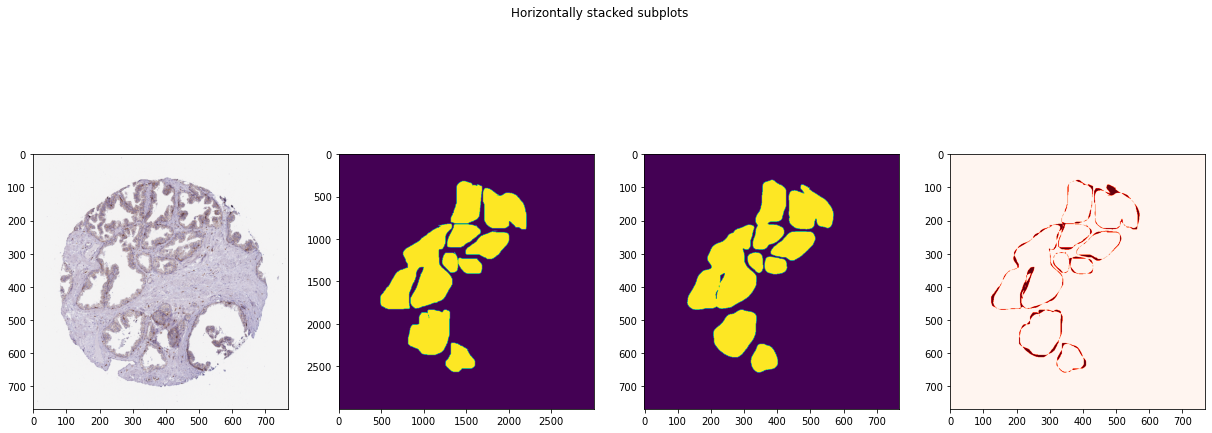

In [188]:
predict(models, test_dataset, 0)               